In [2]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(current_dir)  # 루트 디렉터리 경로 추가  # .py
sys.path.append(os.path.dirname(current_dir))  # 상위 디렉터리 경로 추가  # .ipynb

from src.crawling.nst_item_search import *
import pandas as pd

In [17]:
# 네이버 트렌드 데이터 수집 진행


# 품목 리스트
item_name_list = "농어, 광어, 대게, 연어, 우럭, 참돔, 방어".split(', ')

# 1. URL 접속
driver = webdriver.Chrome()

url = "https://datalab.naver.com/"
driver.get(url)                 # URL로 이동

# 기본 옵션 설정

# # 범위 설정 (월 기준)
# select_dropdown_option(driver, "timeDimensionTitle", "//li[contains(@class, '_item_month')]/a")
# # 범위 설정 (주 기준)
# select_dropdown_option(driver, "timeDimensionTitle", "//li[contains(@class, '_item_week')]/a")
# 범위 설정 (일 기준)
select_dropdown_option(driver, "timeDimensionTitle", "//li[contains(@class, '_item_date')]/a")
time.sleep(1)

# 시작 연월 설정
select_dropdown_option(driver, "startYear", "//div[@id='startYearDiv']//li[contains(@class, '_item_2016')]/a")
select_dropdown_option(driver, "startMonth", "//div[@id='startMonthDiv']//li[contains(@class, '_item_01')]/a")
select_dropdown_option(driver, "startDay", "//div[@id='startDayDiv']//li[contains(@class, '_item_01')]/a")
time.sleep(1)

# 종료 연월 설정
select_dropdown_option(driver, "endYear", "//div[@id='endYearDiv']//li[contains(@class, '_item_2024')]/a")
select_dropdown_option(driver, "endMonth", "//div[@id='endMonthDiv']//li[contains(@class, '_item_12')]/a")
select_dropdown_option(driver, "endDay", "//div[@id='endDayDiv']//li[contains(@class, '_item_31')]/a")
time.sleep(1)

# 연령 체크박스 정보
age_info = {
    '06_12': "item_age_1",
    '13_18': "item_age_2",
    '19_24': "item_age_3",
    '25_29': "item_age_4",
    '30_34': "item_age_5",
    '35_39': "item_age_6",
    '40_44': "item_age_7",
    '45_49': "item_age_8",
    '50_54': "item_age_9",
    '55_59': "item_age_10",
    '60_80': "item_age_11",
}

trend_data = []
for age in age_info:
    for uncheck in age_info.values():  # 체크박스 초기화
        toggle_checkbox(driver, uncheck, check=False)
    toggle_checkbox(driver, age_info[age], check=True)
    # for gt in game_trend_list:
    #     input_keywords(driver, gt)  # 키워드 입력
    for item in item_name_list:
        # if (age, item) in [(t['age'], t['name']) for t in trend_data]:
        #     continue
        input_keyword(driver, baseline_keyword="회", input_keyword=item+",회")  # 키워드 입력
        search_btn = driver.find_element(
            By.CSS_SELECTOR,
            "#content > div._search_trend_wrapper > div.keyword_trend > div > div > form > fieldset > a, #content > div.section_keyword > div.keyword_trend > div.section_step > div.com_box_inner > form > fieldset > a"
        )
        search_btn.click()  # 조회버튼 클릭
        print(age, item, end="/")
        # print(gt)
        time.sleep(2)
        # trend_score = extract_relative_trend_score(driver)
        chart_class_list = ["bb-target-data" + str(i) for i in range(2)]
        score_tmp = []
        for chart_class in chart_class_list:
            circles = driver.find_elements(By.CSS_SELECTOR, f"g.{chart_class} circle")
            data_points = []
            for circle in circles:
                cy = circle.get_attribute("cy")  # cy 속성 추출
                if cy:  # cy 값이 존재하는 경우만 추가
                    # data_points.append(469 - float(cy))
                    # for g, s in zip(gt, trend_score):
                    data_points.append(469 - float(cy))
            score_tmp.append(data_points)
        for i, s in enumerate(zip(*score_tmp)):
            trend_data.append({
                "idx": i,
                "age": age,
                "name": item,
                "score": s[1]/s[0]
            })
        print(len([t for t in trend_data if t["name"] == item and t["age"] == age]))


30_34 농어/3288
30_34 광어/3288
30_34 대게/3288
30_34 연어/3288
30_34 우럭/3288
30_34 참돔/3288
30_34 방어/3288
35_39 농어/3288
35_39 광어/3288
35_39 대게/3288
35_39 연어/3288
35_39 우럭/3288
35_39 참돔/3288
35_39 방어/3288


In [15]:
for i, j in enumerate(zip(*[[1,2,3], [2,3,4]])):
    print(i, j)

0 (1, 2)
1 (2, 3)
2 (3, 4)


In [20]:
df_trend_data = pd.DataFrame(trend_data)
df_trend_data['score'] = df_trend_data['score'] - 1
df_trend_data

# 데이터프레임 생성
df_trend_data = pd.DataFrame(trend_data)

# 시작 날짜 설정
start_date = pd.Timestamp("2016-01-01")

# idx를 날짜로 변환
df_trend_data['date'] = start_date + pd.to_timedelta(df_trend_data['idx'], unit='D')

# 변환된 데이터 확인
print(df_trend_data[['idx', 'date', 'score']].head())

# 데이터 저장 (옵션)
df_trend_data.to_csv("../data/fish_trend_test.csv", index=False)

   idx       date     score
0    0 2016-01-01  1.836360
1    1 2016-01-02  1.868297
2    2 2016-01-03  1.571802
3    3 2016-01-04  1.886129
4    4 2016-01-05  1.429386


### 데이터 분석 및 시각화


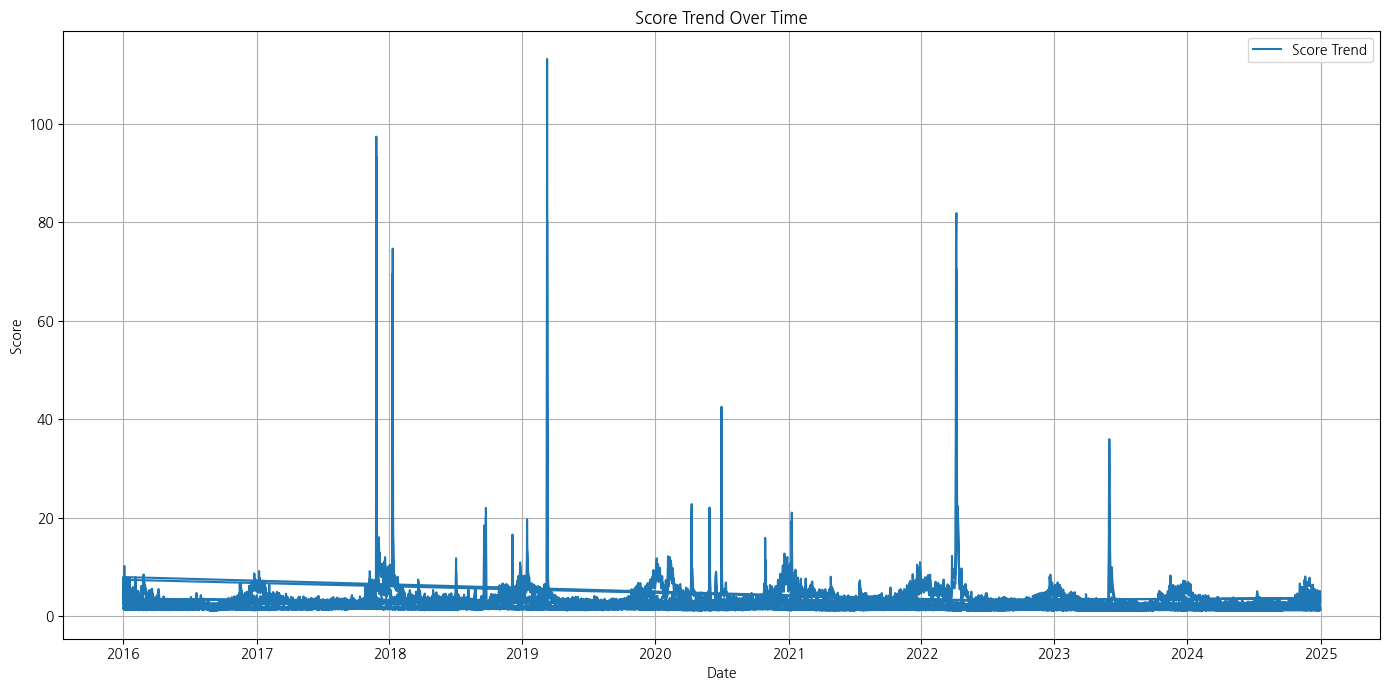

In [23]:
# 전체 데이터 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.figure(figsize=(14, 7))
plt.plot(df_trend_data['date'], df_trend_data['score'], label='Score Trend')
plt.title('Score Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


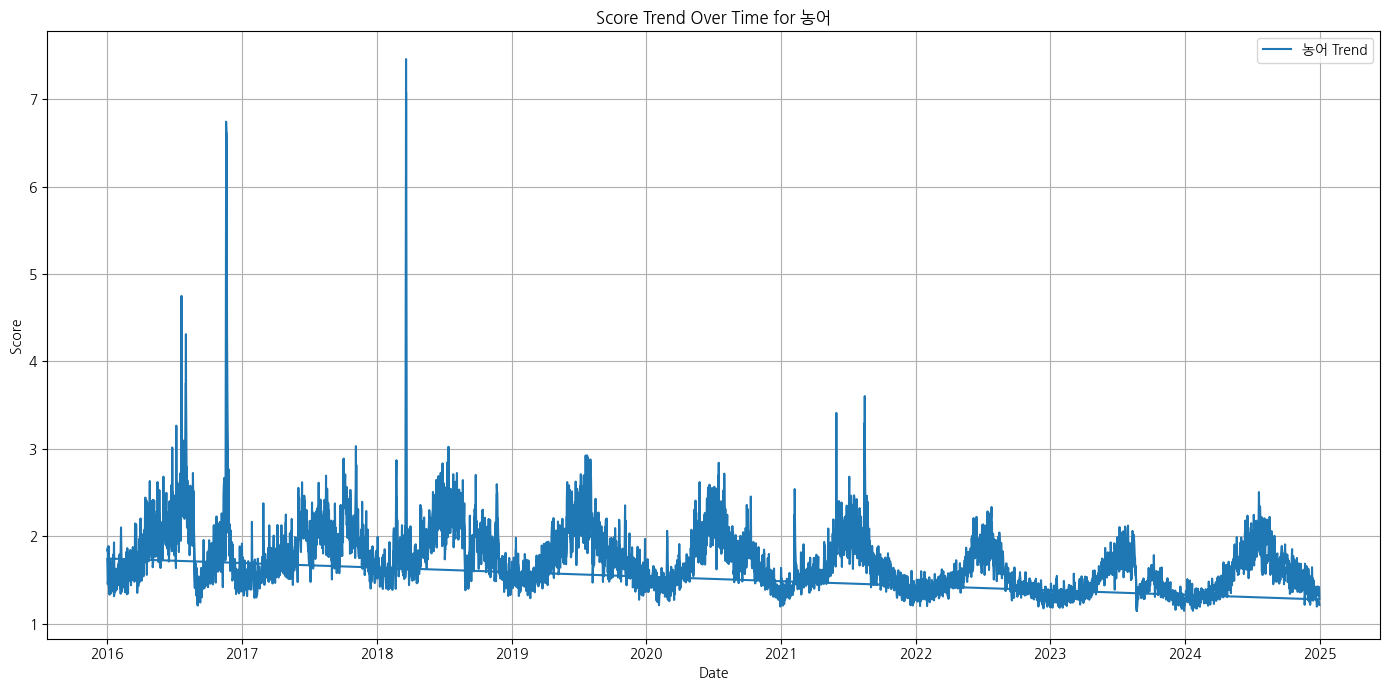

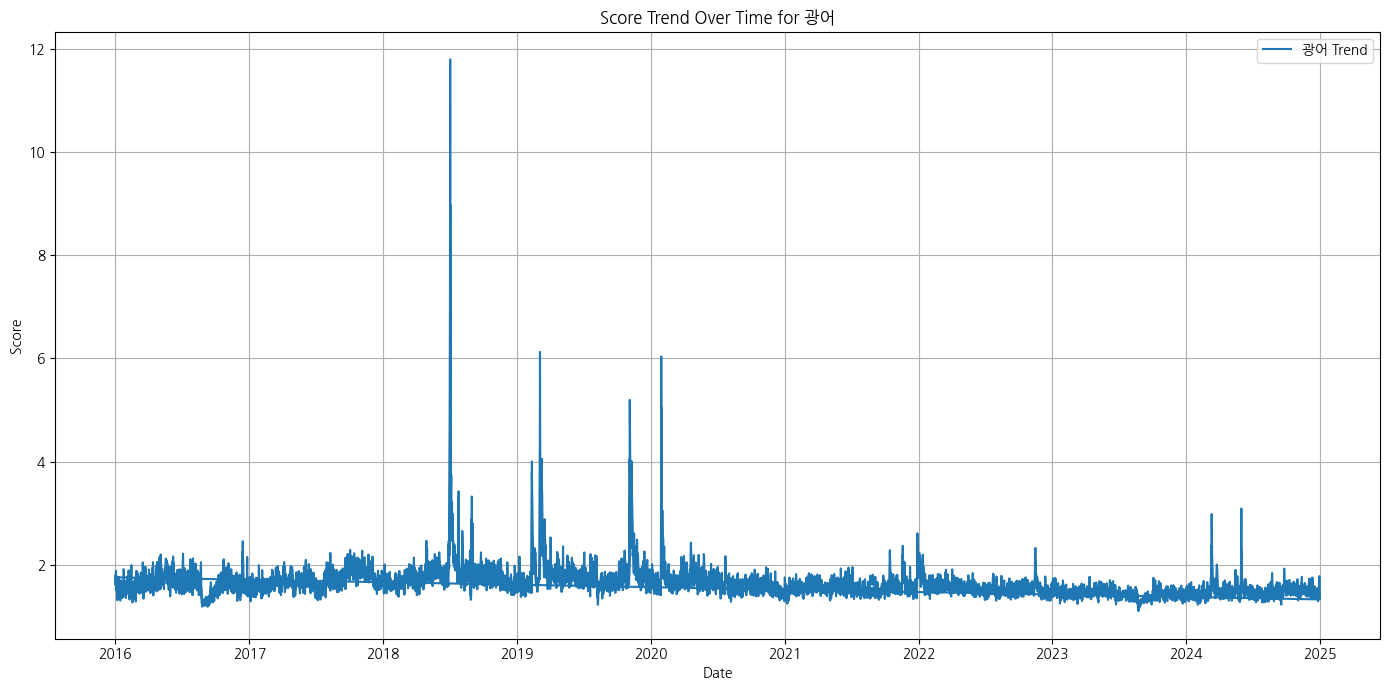

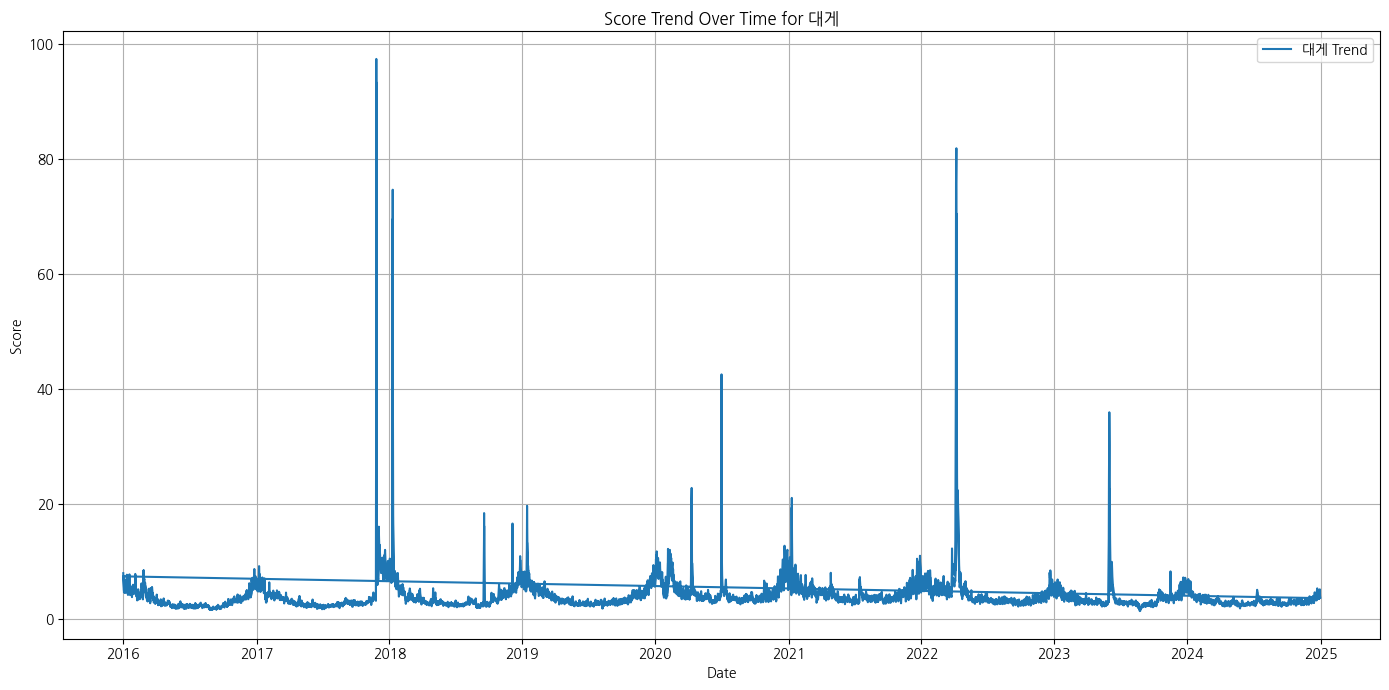

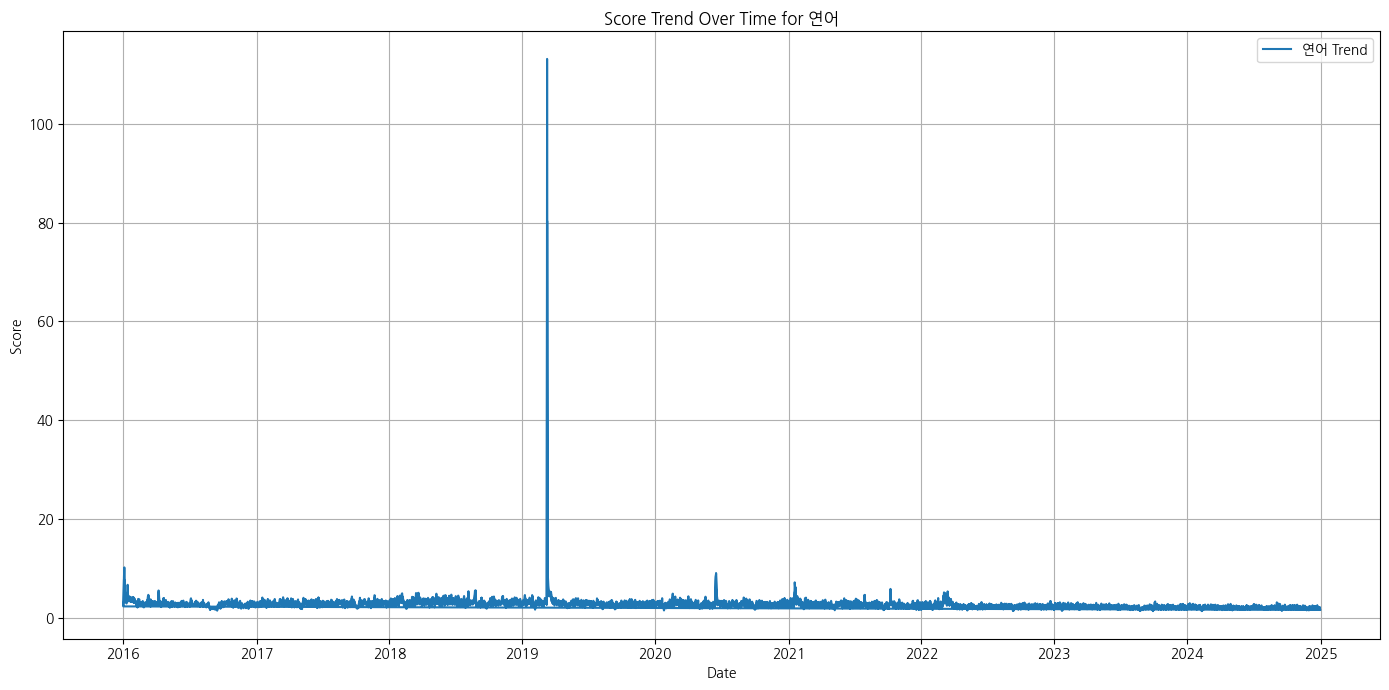

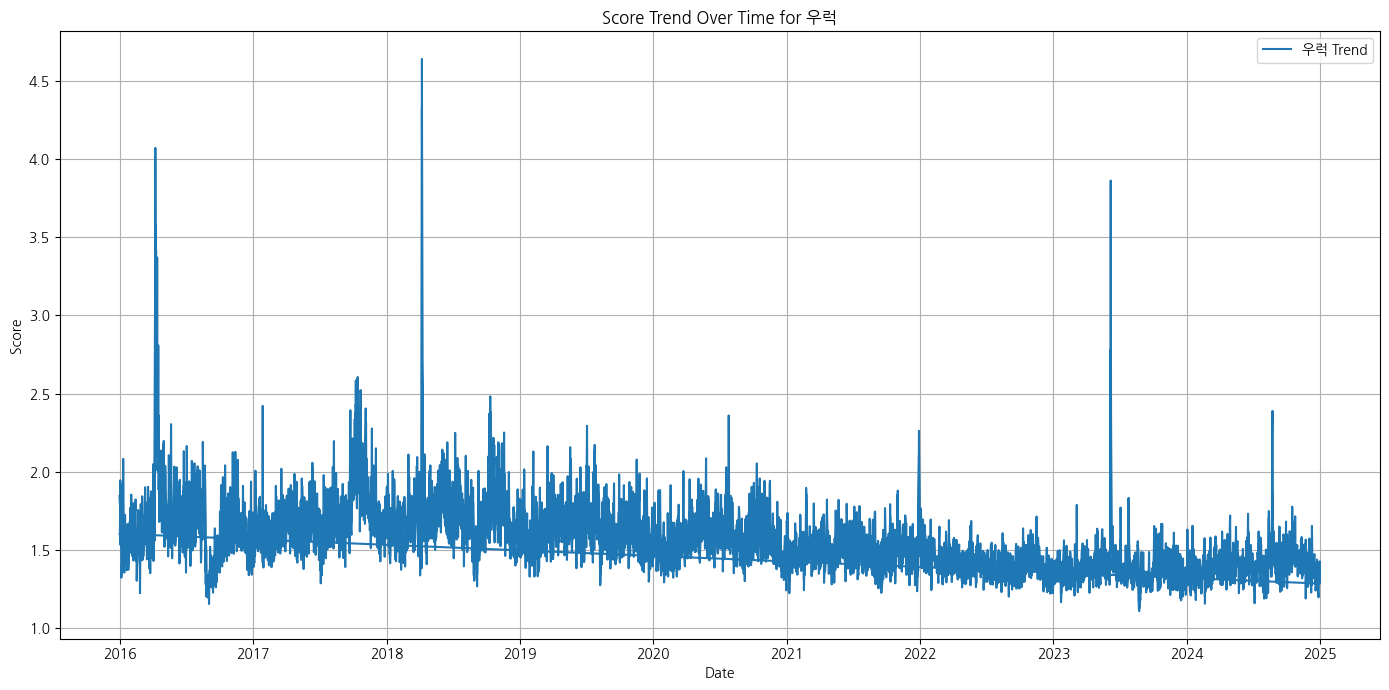

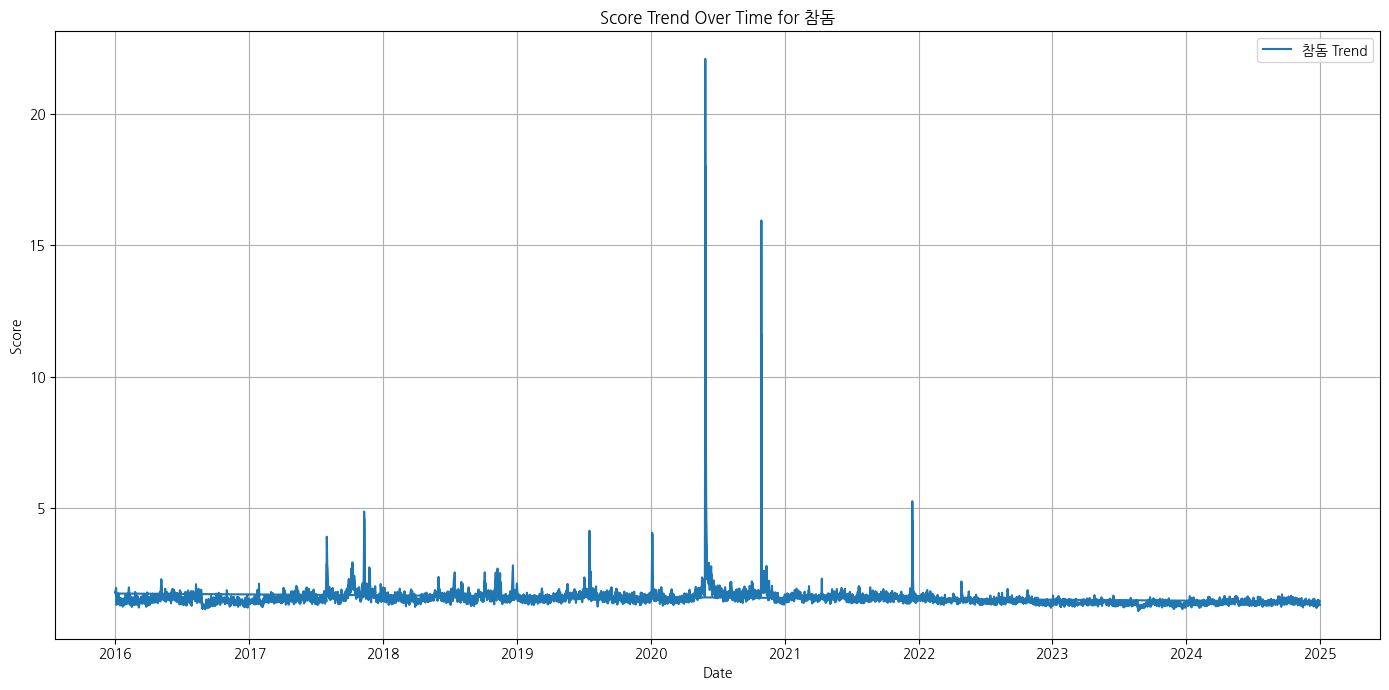

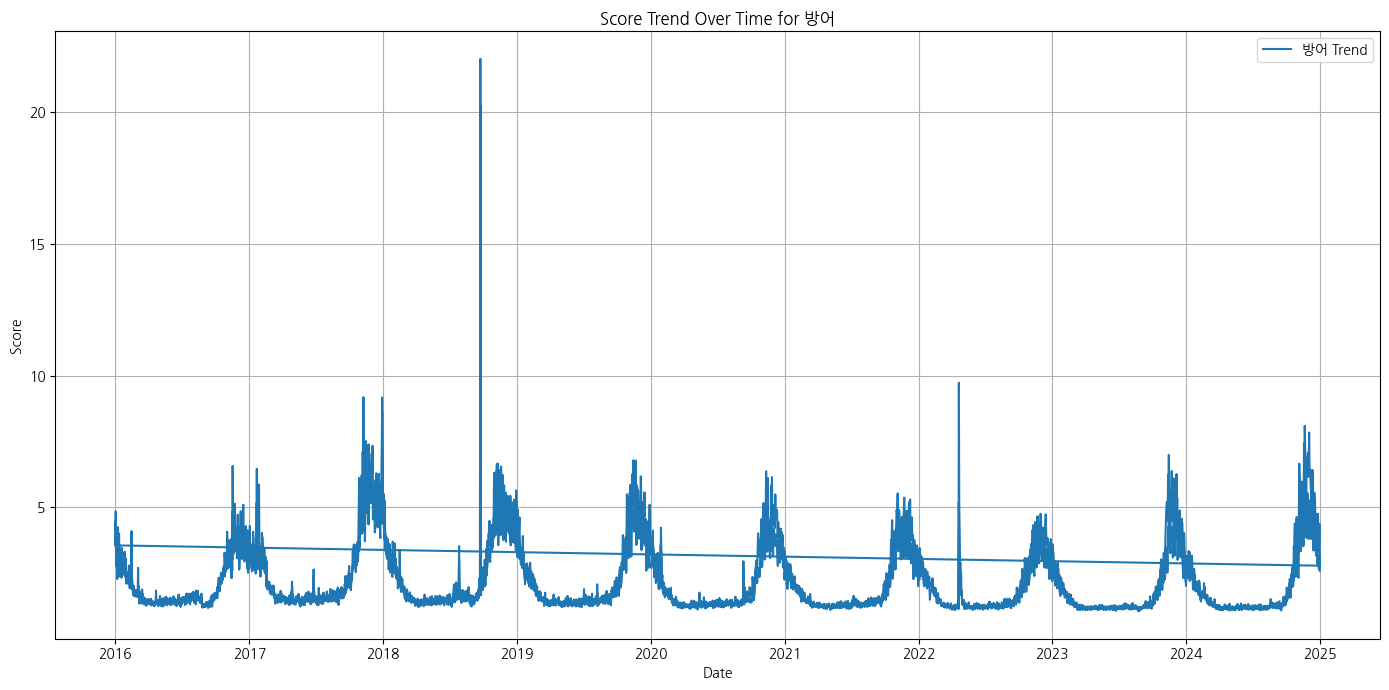

In [24]:
for name in df_trend_data['name'].unique():
    subset = df_trend_data[df_trend_data['name'] == name]
    plt.figure(figsize=(14, 7))
    plt.plot(subset['date'], subset['score'], label=f'{name} Trend')
    plt.title(f'Score Trend Over Time for {name}')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

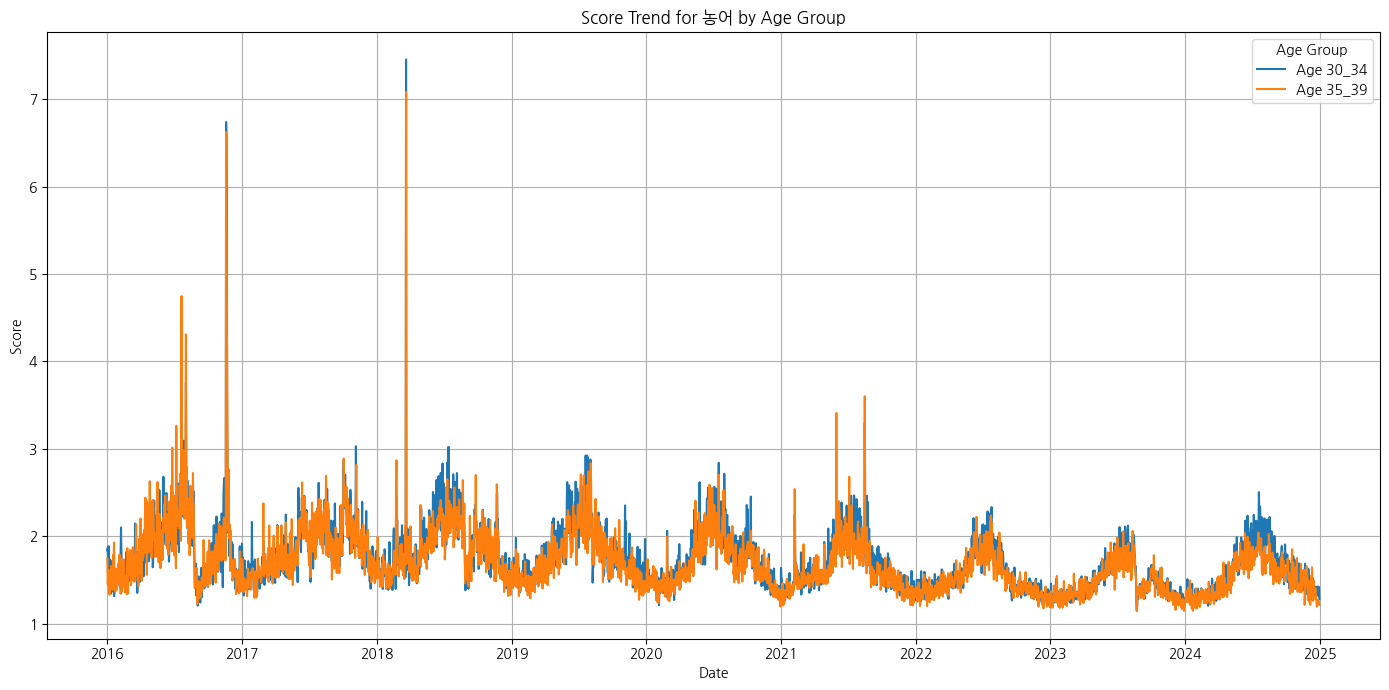

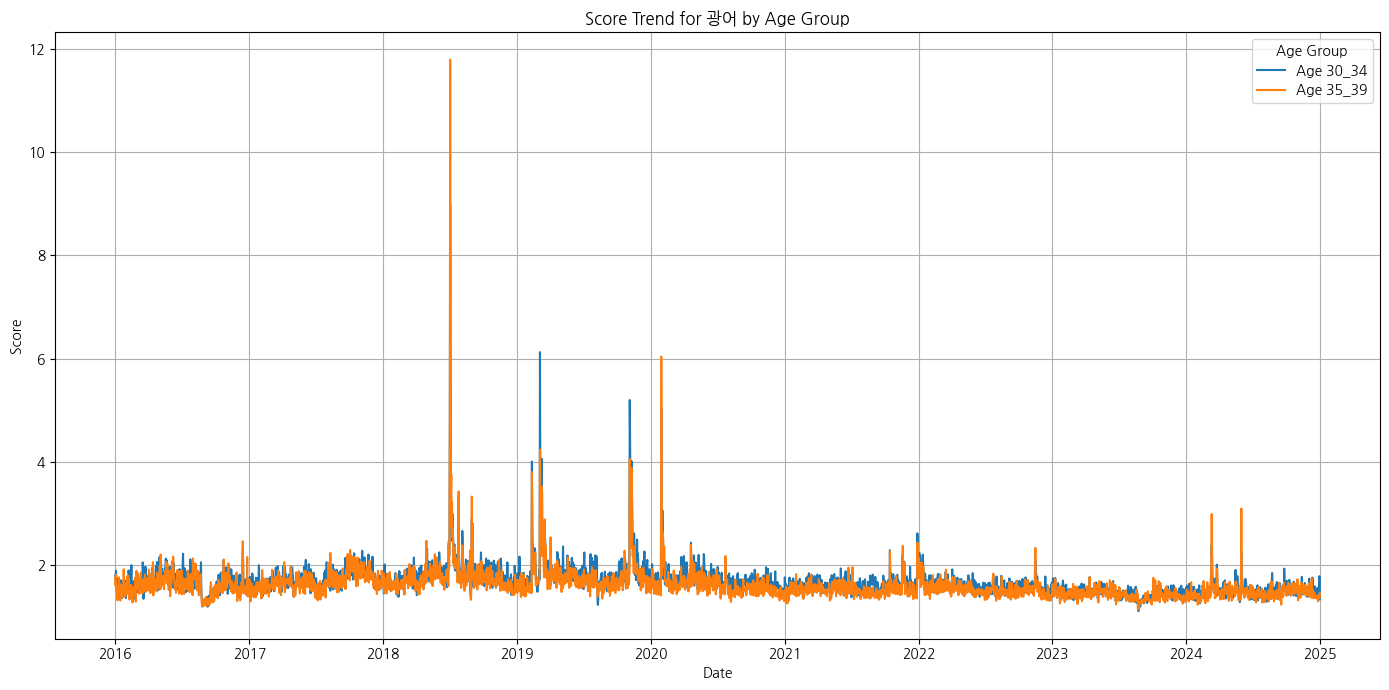

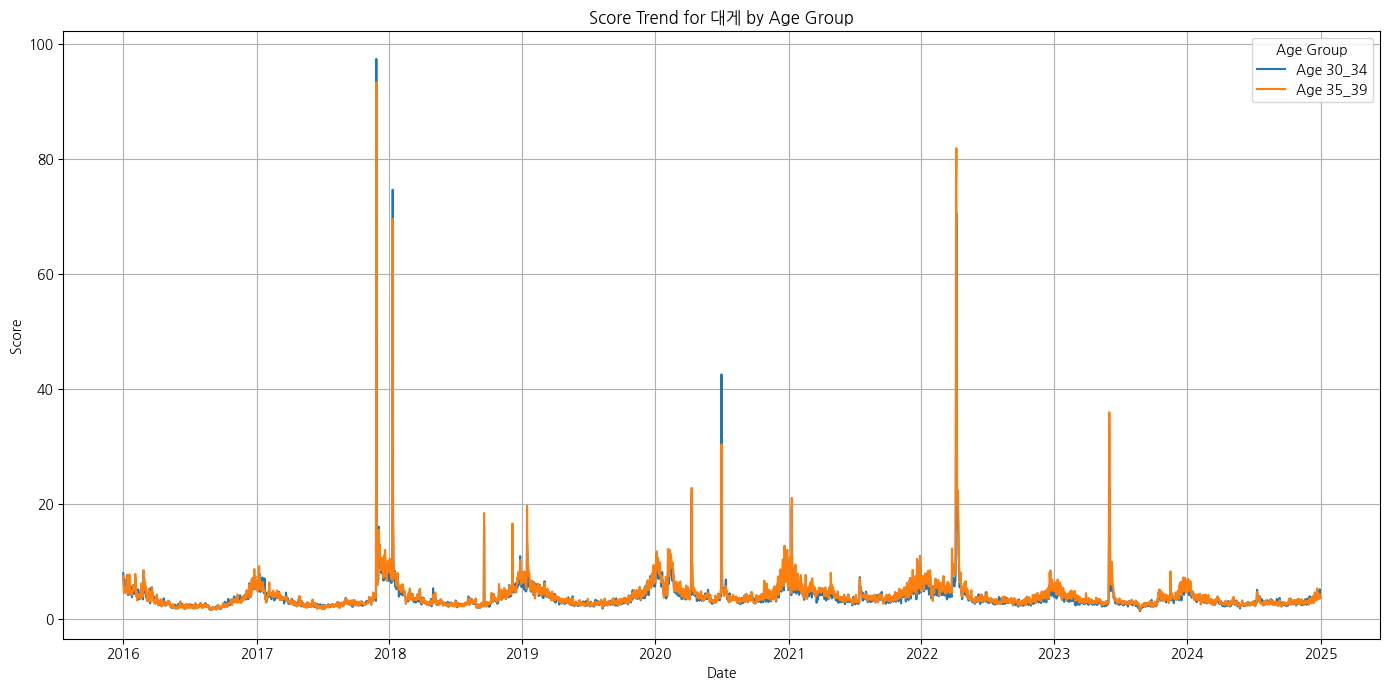

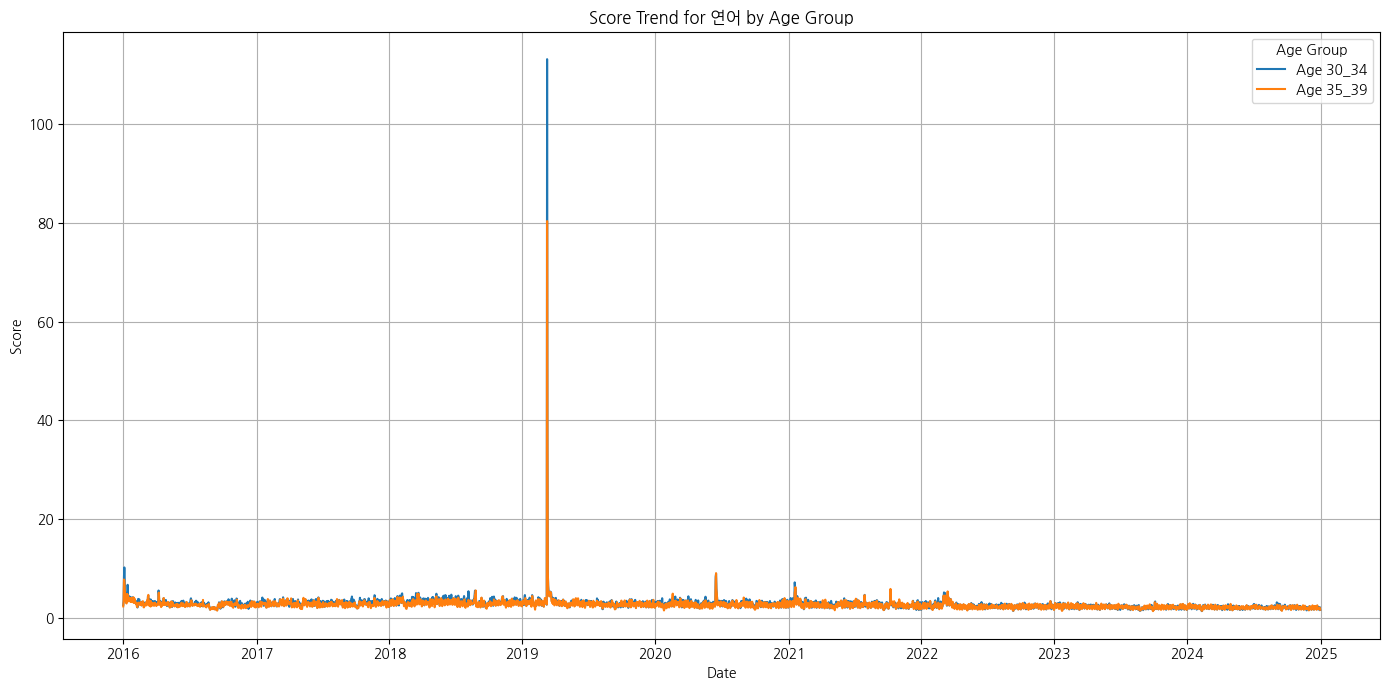

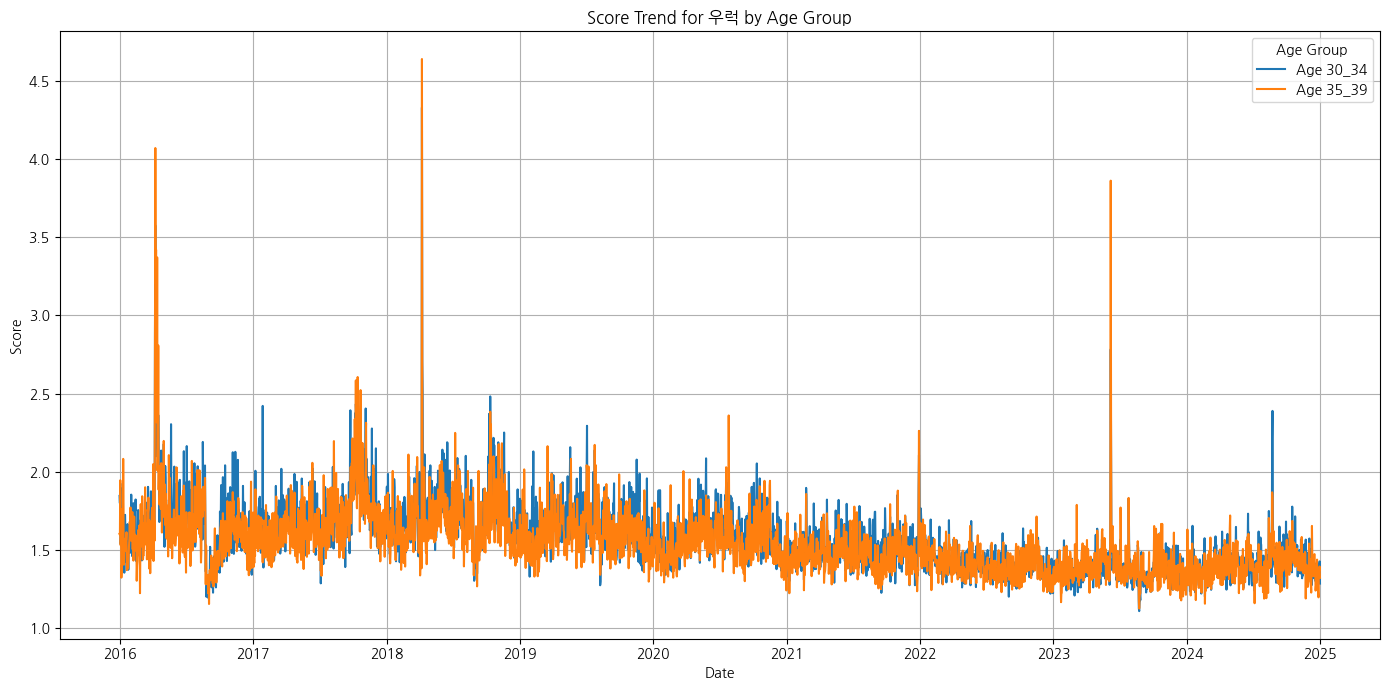

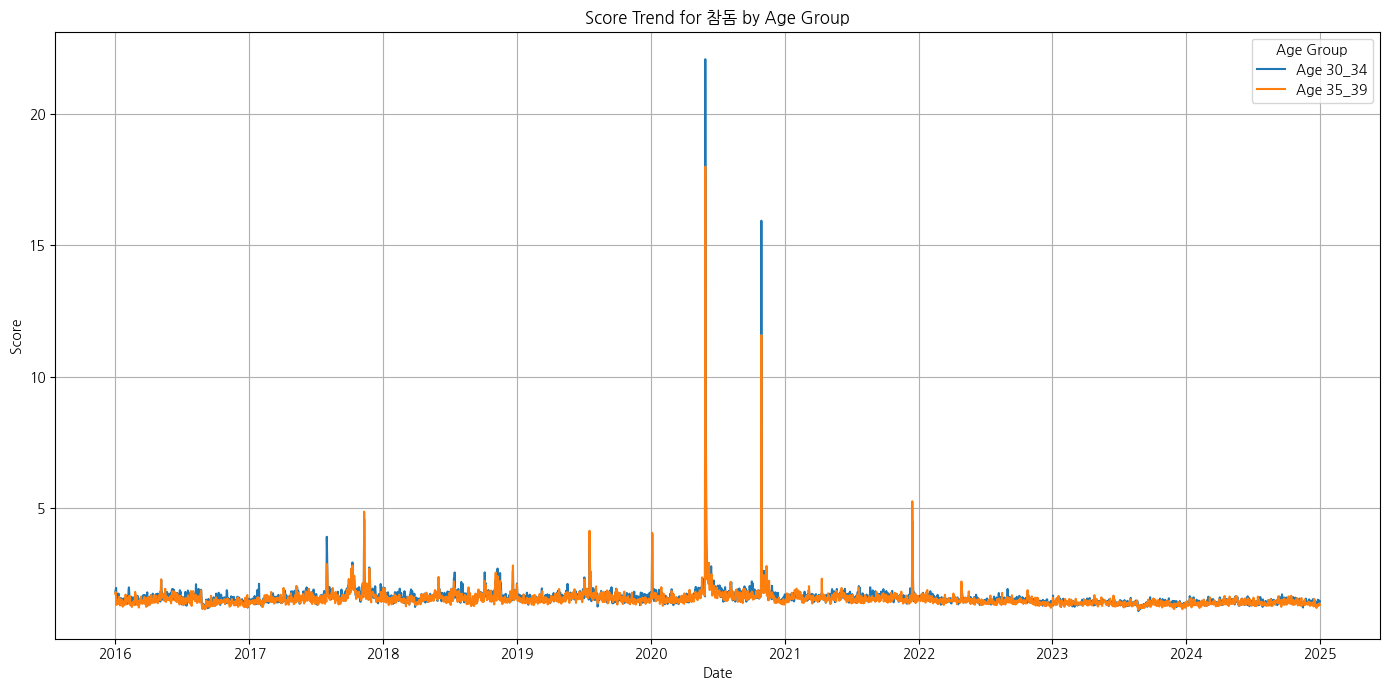

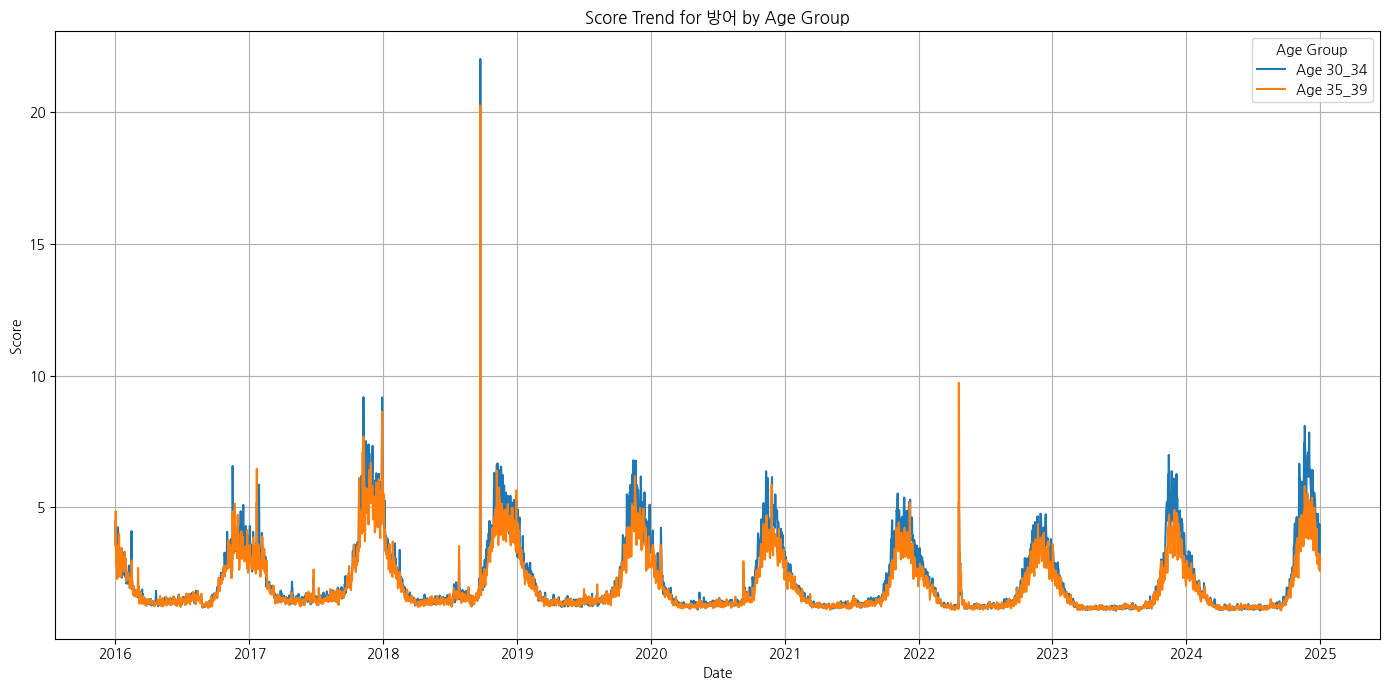

In [25]:
# 유니크한 품목(name)을 순회하며 시각화
for name in df_trend_data['name'].unique():
    plt.figure(figsize=(14, 7))
    
    # 특정 품목 데이터 필터링
    subset = df_trend_data[df_trend_data['name'] == name]
    
    # age 별로 시각화
    for age_group in subset['age'].unique():
        age_subset = subset[subset['age'] == age_group]
        plt.plot(
            age_subset['date'], 
            age_subset['score'], 
            label=f'Age {age_group}'
        )
    
    # 그래프 꾸미기
    plt.title(f'Score Trend for {name} by Age Group')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.legend(title='Age Group')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
